<a href="https://colab.research.google.com/github/yeipi-mora/personal-projects/blob/main/pp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Regression Models to Forecast Time Series**

The code below includes several models to forecast time series. The considered models are:


1.   A deep LSTM recurrent nerual network.
2.   Hybrids model combining convolutional and LSTM layers with different configurations.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error

def generate_data(path, n_steps, drop_columns=["timestamp"]):
  data = pd.read_csv(path).drop(columns=drop_columns).astype("float32")
  data["h-l"] = data["high"]-data["low"]
  data["c-o"] = data["close"]-data["open"]
  data["var"] = ((data["close"]-data["open"]) / data["open"]) * 100
  data["5avg"] = data["close"].rolling(window=5).mean()
  data["7avg"] = data["close"].rolling(window=7).mean()
  data["11avg"] = data["close"].rolling(window=11).mean()
  data = data.dropna()
  scaler = MinMaxScaler()
  scaler.fit(data)
  data = scaler.transform(data)
  X = list()
  y = list()
  for i in range(len(data)-n_steps):
    X.append(data[i:i+n_steps])
    y.append(data[i+n_steps,3])
  return data, np.array(X), np.array(y).reshape(-1,1)

def scale(sc, y):
  return sc.fit_transform(y)

def inverse_scale(sc, y):
  return sc.inverse_transform(y)

def plot_loss(history, name=''):
  plt.plot(history.history['loss'], label='Training Loss', color='navy')
  plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss '+name)
  plt.legend()
  plt.show()

def model_metrics(model, X_test, y_test, batch_size):
  y_hat = model.predict(X_test, batch_size=batch_size, verbose=0)
  try:
    acc = accuracy_score(y_test, y_hat)
    print("ACCURACY:\t", acc)
  except:
    pass
  mse = mean_squared_error(y_test, y_hat)
  print("MEAN SQUARED ERROR:\t", mse)

def plot_pred_vs_original(y, y_hat, sc, xlabel='', ylabel=''):
  fig, ax = plt.subplots(1)
  y = inverse_scale(sc, y)
  y_hat = inverse_scale(sc, y_hat)
  ax.plot(y, label='Original', color='navy')
  ax.plot(y_hat, label='Prediction', color='coral')
  ax.legend(loc='upper right')
  ax.set_xlabel(xlabel, fontsize = 16)
  ax.set_ylabel(ylabel, fontsize = 16)
  plt.show()

def dlstm():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(100, return_sequences=True))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.LSTM(100, return_sequences=True))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.LSTM(100))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mse', optimizer='adam')
  return model

def cnn(config):
  # config = array with filters, kernel_size
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=config[0], kernel_size=config[1], activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.MaxPooling1D(pool_size=config[-1]))
  model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def cnnlstm1(config):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=config[0], kernel_size=config[2],
                                   activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Conv1D(filters=config[1], kernel_size=config[2],
                                   activation='relu'))
  model.add(tf.keras.layers.MaxPooling1D(pool_size=config[3]))
  model.add(tf.keras.layers.LSTM(units=config[-1]))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
  model.compile(loss='mse', optimizer='adam')
  return model

def cnnlstm2(config):
  # config = array with filters, kernel_size, pool_size and units for lstm, and size of fully conected layer.
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=config[0], kernel_size=config[2],
                                   activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
  model.add(tf.keras.layers.Conv1D(filters=config[1], kernel_size=config[2],
                                   activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
  model.add(tf.keras.layers.MaxPooling1D(pool_size=config[3]))
  model.add(tf.keras.layers.LSTM(units=config[4],
                                  kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)
                                 ))
  model.add(tf.keras.layers.Dense(config[-1], kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
  model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def dcnnlstm(config_cnn, config_lstm):
  model = tf.keras.models.Sequential()
  # CNN model
  for i in range(1,len(config_cnn)):
    model.add(tf.keras.layers.Conv1D(filters=config_cnn[i], kernel_size=config_cnn[0],
                                    activation='relu'))
  model.add(tf.keras.layers.MaxPooling1D(pool_size=config_cnn[0]))
  model.add(tf.keras.layers.Dropout(0.2))

  #LSTM layers
  model.add(tf.keras.layers.LSTM(config_lstm[2], input_shape=(config_lstm[0],config_lstm[1]),
                                return_sequences=True))
  model.add(tf.keras.layers.Dropout(0.2))
  for i in range(1,len(config_lstm)):
    model.add(tf.keras.layers.LSTM(config_lstm[i],return_sequences=i<len(config_lstm)-1))
    model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2=0.1)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def train_model(model, path, n_steps, name,
                n_features=1, batch_size=32, n_epochs=100, patience=10,
                drop_columns=["timestamp"]):
    _, X, y = generate_data(path, n_steps, drop_columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), verbose=2, shuffle=False,
                        callbacks=[early_stopping])
    model_metrics(model, X_test, y_test, batch_size)
    model.save(f'/content/drive/MyDrive/Forecasting/model-{name.lower()}.h5')
    print(f'MODEL {name} SAVED')
    plot_loss(history, name=name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/200
57/57 - 21s - loss: 0.0151 - val_loss: 0.0418 - 21s/epoch - 361ms/step
Epoch 2/200
57/57 - 11s - loss: 0.0107 - val_loss: 0.0347 - 11s/epoch - 185ms/step
Epoch 3/200
57/57 - 13s - loss: 0.0177 - val_loss: 0.0317 - 13s/epoch - 219ms/step
Epoch 4/200
57/57 - 9s - loss: 0.0207 - val_loss: 0.0321 - 9s/epoch - 163ms/step
Epoch 5/200
57/57 - 12s - loss: 0.0340 - val_loss: 0.0204 - 12s/epoch - 219ms/step
Epoch 6/200
57/57 - 10s - loss: 0.0467 - val_loss: 0.0117 - 10s/epoch - 168ms/step
Epoch 7/200
57/57 - 10s - loss: 0.0399 - val_loss: 0.0108 - 10s/epoch - 179ms/step
Epoch 8/200
57/57 - 11s - loss: 0.0284 - val_loss: 0.0215 - 11s/epoch - 200ms/step
Epoch 9/200
57/57 - 9s - loss: 0.0228 - val_loss: 0.0169 - 9s/epoch - 161ms/step
Epoch 10/200
57/57 - 10s - loss: 0.0142 - val_loss: 0.0137 - 10s/epoch - 184ms/step
Epoch 11/200
57/57 - 11s - loss: 0.0067 - va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


MODEL DLSTM SAVED


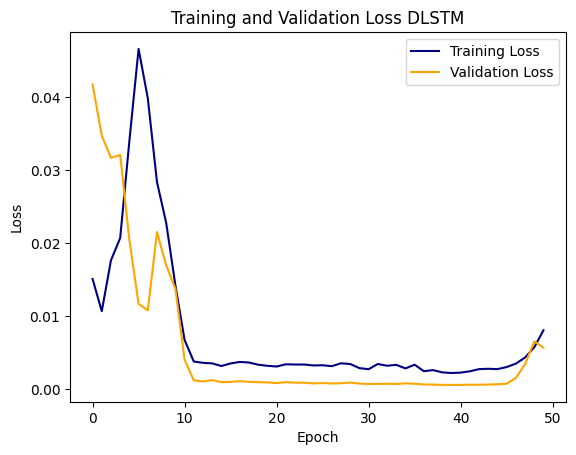

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
model = dlstm()
_, X, y = generate_data("/content/drive/MyDrive/Forecasting/timeseries.csv", 60)
train_model(model=model, path="/content/drive/MyDrive/Forecasting/timeseries.csv",
            n_steps=60, name="DLSTM", n_epochs=200)